In [370]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random as random
from copy import deepcopy

In [1]:
# 1 Assignment - kmeans algorithm

In [485]:
def kmeans(X, k, max_iter=100):
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    # initailize k random centroids at data mean
    X_mean = np.mean(X, axis = 0)
    w_init = np.array([np.random.normal(X_mean[i],1,k) for i in range(len(X_mean))])
    w_q = w_init
    converged = False
    iteration = 1
    m_q = np.zeros(len(X))
    m_q_old = deepcopy(m_q)
    while (not converged) & (iteration <= max_iter):
        # calculate distance to centroids
        D = np.linalg.norm(X[None, :] - w_q.T[:,None], axis = 2)
        # assign every data point to its nearest centroids
        m_q = np.argmin(D, axis=0)
        # assign random data point to not empty centroids
        m_empty = [x for x in range(k) if x not in np.unique(m_q)]
        for m in m_empty:
            m_q[random.randint(0,len(X)-1)] = m
        # calculate position of centroids as mean of assigned data
        w_q.T[np.unique(m_q)] = [np.sum(X[m_q == j], axis = 0) / (np.sum(m_q == j)) for j in np.unique(m_q)]
        
        # calculate objective
        loss = np.sum([np.sum((X[m_q == j, :] - w_q[:,j])**2) for j in np.unique(m_q)])
        print('iteration-step: ' + str(iteration))
        print('number of changes in assignment: ' + str(list(m_q == m_q_old).count(False)))
        print('loss function value: ' + str(loss))
        if (m_q == m_q_old).all():
            converged = True
            break
        
        m_q_old = deepcopy(m_q)
        iteration+=1
    return w_q.T, m_q, loss

In [486]:
# Test set
k=3
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
                  [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
perfect_r = [1,0,1,2,2,1,2,2,2]

In [487]:
mu, r, loss =  kmeans(X,3)

iteration-step: 1
number of changes in assignment: 4
loss function value: 118.70833333333333
iteration-step: 2
number of changes in assignment: 2
loss function value: 2.7500000000000004
iteration-step: 3
number of changes in assignment: 0
loss function value: 2.7500000000000004


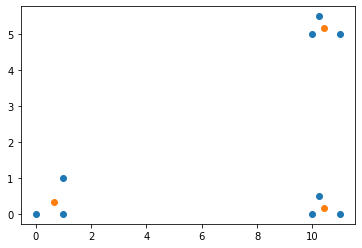

In [489]:
plt.plot(X[:,0], X[:,1], 'o')
plt.plot (mu.T[0], mu.T[1], 'o')